In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 10.1

In [2]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1

#### Code 10.2

In [3]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(2000)

100%|██████████| 2500/2500 [00:30<00:00, 81.41it/s]


In [4]:
df_10_1 = pm.df_summary(trace_10_1, alpha=0.11)
df_10_1.round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
a,0.32,0.09,0.00,0.18,0.46
bp,-0.34,10.12,0.15,-15.80,16.13


#### Code 10.3

In [5]:
logistic(df_10_1.iloc[:,-2:]).round(2)

,hpd_5.5,hpd_94.5
a,0.54,0.61
bp,0.00,1.00


#### Code 10.4

In [6]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(2000)

with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(2000)

100%|██████████| 2500/2500 [01:14<00:00, 33.68it/s]


#### Code 10.5

In [7]:
comp_df = pm.compare(traces=[trace_10_1, trace_10_2, trace_10_3],
                     models=[model_10_1, model_10_2, model_10_3],
                     method='pseudo-BMA')
comp_df.round(2)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,680.53,2.02,0,0.7,9.41,0,0
2,682.34,3,1.8,0.28,9.39,0.83,0
0,687.88,0.97,7.35,0.02,7.15,6.24,0


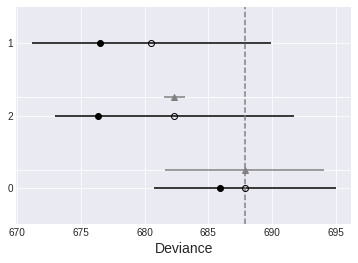

In [8]:
pm.compareplot(comp_df);

#### Code 10.6

In [9]:
pm.df_summary(trace_10_3).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.05,0.13,0.00,-0.19,0.31
bp,0.61,0.22,0.01,0.18,1.05
bpC,-0.11,0.27,0.01,-0.62,0.39


#### Code 10.7

In [10]:
np.exp(0.61)

1.8404313987816374

#### Code 10.8

In [11]:
logistic(4)

0.98201379003790845

#### Code 10.9

In [12]:
logistic(4 + 0.61)

0.99014624447676869

#### Code 10.10 and 10.11

In [13]:
d_pred = pd.DataFrame({'prosoc_left' : [0, 1, 0, 1], 'condition' : [0, 0, 1, 1]})
traces = [trace_10_1, trace_10_2, trace_10_3]
models = [model_10_1, model_10_2, model_10_3]


chimp_ensemble = pm.sample_ppc_w(traces=traces, models=models, samples=1000, 
                                 weights=comp_df.weight.sort_index(ascending=True))

100%|██████████| 1000/1000 [00:04<00:00, 227.96it/s]


In [82]:
rt = chimp_ensemble['pulled_left']
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left==pl) & (d.chose_prosoc==cp)]))
    pred_mean[i] = tmp
    
ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
for i in range(7):
    plt.plot(chimps[i], 'C0')

plt.ylim(0, 1.1);

IndexError: too many indices for array

#### Code 10.12 & 10.13
This is the same as 10.6, but in the book using MCMC rather than quadratic approximation.

#### Code 10.14

In [18]:
with pm.Model() as model_10_4:
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(2000)

 78%|███████▊  | 1943/2500 [03:36<01:02,  8.97it/s]/home/agustina/anaconda3/lib/python3.5/site-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 10 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [04:10<00:00,  9.97it/s]


#### Code 10.15

In [19]:
# remember we use a zero-index
d['actor'].unique()

array([0, 1, 2, 3, 4, 5, 6])

#### Code 10.16

In [20]:
pm.df_summary(trace_10_4, alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha__0,-0.75,0.27,0.00,-1.20,-0.34
alpha__1,11.24,5.58,0.14,3.27,18.75
alpha__2,-1.06,0.28,0.00,-1.53,-0.64
alpha__3,-1.06,0.28,0.01,-1.48,-0.59
alpha__4,-0.75,0.27,0.01,-1.16,-0.30
alpha__5,0.21,0.27,0.00,-0.23,0.63
alpha__6,1.82,0.38,0.01,1.21,2.42
bp,0.84,0.26,0.01,0.44,1.26
bpC,-0.14,0.30,0.01,-0.61,0.35


#### Code 10.17

In [21]:
post = pm.trace_to_dataframe(trace_10_4)
post.head()

,bp,bpC,alpha__0,alpha__1,alpha__2,alpha__3,alpha__4,alpha__5,alpha__6
0,0.858356,0.020622,-0.627092,11.767471,-1.219927,-1.084652,-0.810191,0.479901,2.179455
1,0.810698,-0.272230,-0.822731,17.964828,-1.321517,-0.965018,-0.880570,0.529529,2.408210
2,0.768482,-0.286192,-0.739695,18.745527,-1.370155,-1.152026,-0.752067,0.499289,2.564550
3,0.927384,-0.178712,-0.736614,23.973036,-1.108530,-1.312878,-0.694916,0.559086,1.711767
4,0.898291,-0.244631,-0.792693,25.681210,-1.042947,-1.425626,-0.531843,0.326976,1.990875


#### Code 10.18

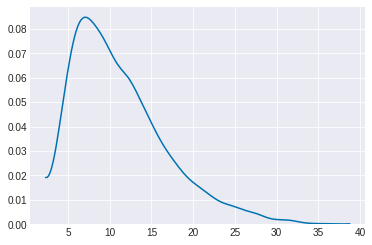

In [22]:
pm.kdeplot(post['alpha__1']);

#### Code 10.19

In [23]:
rt = pm.sample_ppc(trace_10_4, 1000, model_10_4)['pulled_left']

100%|██████████| 1000/1000 [00:14<00:00, 69.48it/s]


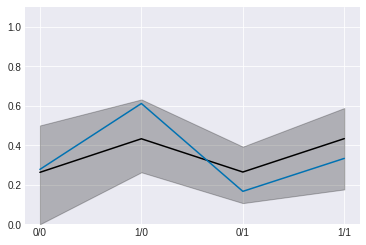

In [24]:
chimp = 2
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left == pl) & (d.chose_prosoc == cp) & (d.actor == chimp)]))
    pred_mean[i] = tmp

ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean, alpha=0.11)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d[d.actor == chimp].groupby(['condition', 'prosoc_left', ]).agg('mean')['pulled_left'].values
plt.plot(chimps, 'C0')

plt.ylim(0, 1.1);

#### Code 10.20

In [25]:
d_aggregated = d.groupby(['actor', 'condition', 'prosoc_left',  ])['pulled_left'].sum().reset_index()
d_aggregated.head(7)

,actor,condition,prosoc_left,pulled_left
0,0,0,0,6
1,0,0,1,9
2,0,1,0,5
3,0,1,1,10
4,1,0,0,18
5,1,0,1,18
6,1,1,0,18


#### Code 10.21

In [26]:
with pm.Model() as model_10_5:
    a = pm.Normal('alpha', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d_aggregated.condition) * d_aggregated.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_10_5 = pm.sample(2000)

100%|██████████| 2500/2500 [01:23<00:00, 29.80it/s]


In [27]:
pm.df_summary(trace_10_5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.047341,0.125471,0.002402,-0.185356,0.299667
bp,0.617887,0.223174,0.004078,0.167482,1.021358
bpC,-0.109395,0.257499,0.005108,-0.585989,0.420310


In [28]:
# hacky check of similarity to 10_3, within a hundreth
np.isclose(pm.df_summary(trace_10_5), pm.df_summary(trace_10_3), atol=0.01)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True, False, False],
       [ True,  True,  True, False, False]], dtype=bool)

#### Code 10.22

In [29]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


#### Code 10.23

In [30]:
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)

with pm.Model() as model_10_6:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a + bm * d_ad.male)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_6 = pm.sample(2000, tune=1000)
    
with pm.Model() as model_10_7:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_7 = pm.sample(2000, tune=1000)

100%|██████████| 3000/3000 [00:46<00:00, 64.98it/s]


#### Code 10.24

In [31]:
# Something goofy here... 
# not even close to WAIC values, larger standard error

comp_df = pm.compare([trace_10_6, trace_10_7], [model_10_6, model_10_7], method='pseudo-BMA')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
0,991.46,112.65,0,1,312.73,0,1
1,1046.67,83.32,55.21,0,313.79,155.85,1


#### Code 10.25

In [32]:
pm.df_summary(trace_10_6).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,-0.83,0.05,0.0,-0.92,-0.73
bm,0.61,0.06,0.0,0.49,0.73


#### Code 10.26

In [33]:
post = pm.trace_to_dataframe(trace_10_6)
p_admit_male = logistic(post['a'] + post['bm'])
p_admit_female = logistic(post['a'])
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[.025, .5, .975])[['2.5%', '50%', '97.5%']]

2.5%     0.113798
50%      0.141242
97.5%    0.169309
dtype: float64

#### Code 10.27

(0, 1)

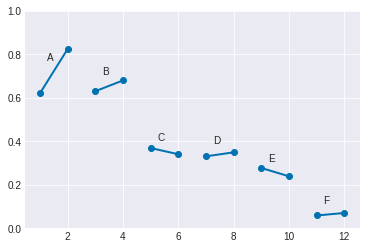

In [34]:
for i in range(6):
    x = 1 + 2 * i
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])
plt.ylim(0, 1)

#### Code 10.28

In [35]:
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

In [36]:
with pm.Model() as model_10_8:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    p = pm.math.invlogit(a[d_ad['dept_id'].values])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_8 = pm.sample(2000)

with pm.Model() as model_10_9:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a[d_ad['dept_id'].values] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_9 = pm.sample(2000)

100%|██████████| 2500/2500 [01:44<00:00, 23.86it/s]


#### Code 10.29

In [37]:
# WAIC values still off
# Plus warning flag

comp_df = pm.compare(traces=[trace_10_6, trace_10_7, trace_10_8, trace_10_9],
                     models=[model_10_6, model_10_7, model_10_8, model_10_9], method='pseudo-BMA')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
2,104.9,6.42,0,0.85,17.03,0,1
3,108.42,9.39,3.52,0.15,15.5,3.57,1
0,991.46,112.65,886.56,0,312.73,309.75,1
1,1046.67,83.32,941.77,0,313.79,311.54,1


#### Code 10.30

In [38]:
pm.df_summary(trace_10_9).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a__0,0.68,0.10,0.0,0.50,0.88
a__1,0.64,0.11,0.0,0.41,0.85
a__2,-0.58,0.07,0.0,-0.73,-0.44
a__3,-0.61,0.09,0.0,-0.78,-0.44
a__4,-1.06,0.10,0.0,-1.25,-0.86
a__5,-2.64,0.16,0.0,-2.94,-2.33
bm,-0.10,0.08,0.0,-0.26,0.06


#### Code 10.31
Replicated model above but with MCMC in book.

#### Code 10.32

In [84]:
import statsmodels.api as sm
m10_7glm = sm.OLS(np.concatenate((d_ad['admit'], d_ad['reject'])).reshape(-1, 2), np.array([1]*12))
m10_6glm = sm.OLS(np.concatenate((d_ad['admit'], d_ad['reject'])).reshape(-1, 2), d_ad['male'])
m10_8glm = sm.OLS(np.concatenate((d_ad['admit'], d_ad['reject'])).reshape(-1, 2), d_ad['dept_id'])
m10_9glm = sm.OLS(np.concatenate((d_ad['admit'], d_ad['reject'])).reshape(-1, 2), d_ad['male'] + d_ad['dept_id'])

#### Code 10.33

In [85]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
m10_4glm = sm.OLS(d['pulled_left'], d['actor'] + d['prosoc_left'] * d['condition'] - d['condition'])

#### Code 10.34

In [86]:
pm.GLM.from_formula('pulled_left ~ prosoc_left * condition - condition', data=d)

#### Code 10.35

In [112]:
# outcome and predictro almost perfectly associated
y = np.concatenate((np.repeat(0, 10), np.repeat(1, 10)))
x = np.concatenate((np.repeat(-1, 9), np.repeat(1, 11)))
# fit binomial GLM
m_bad = sm.OLS(y, x)
results = m_bad.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     19.00
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           0.000338
Time:                        17:54:49   Log-Likelihood:                -14.516
No. Observations:                  20   AIC:                             31.03
Df Residuals:                      19   BIC:                             32.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5000      0.115      4.359      0.0

#### Code 10.36

In [ ]:
with pm.Model() as model_good:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    p = pm.math.invlogit(a[d_ad['dept_id'].values])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_8 = pm.sample(2000)

In [39]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.4
IPython 4.1.2
PyMC3 3.2
NumPy 1.13.3
Pandas 0.20.3
SciPy 0.19.1
Matplotlib 2.0.2

